In [1]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()
import pandas as pd
import random
import csv
import math
import statistics
import os
import os.path
from os import path
import time

random.seed(5)
np.random.seed(5)

In [2]:
# set home dir
os.chdir('..//..//')
os.getcwd();

In [3]:
# Out_dir is where you want all of the program output to be. The code will make subfolders for you nicely!
out_dir = 'other//no_meta'
# Data_dir is where all of the stock data is
data_dir = "Data//Stocks_Sector_CC"

days_total = 80
window_size = 15
num_iter_test = 100

num_tasks = 45
epochs = 1000
# Should be 1 for meta-learning
num_iter_meta = 1

sample_size = 10

days_train = int(days_total * 0.7)

In [4]:
def writeCSV(directory, out_type, data):
    identifier = '_e_{}_t_{}_im_{}_it_{}_d_{}_w_{}'
    ident_fill = identifier.format(epochs,num_tasks,num_iter_meta,num_iter_test,days_total,window_size)
    
    # Create subfolders and assign variables based on output type
    if(out_type in ["meta_data","train_data","profit_data","results_data"]):
        if(out_type == "meta_data"):
            folder = out_dir + "/meta"
            if(not path.exists(folder)):    
                os.mkdir(folder)
            cols = ["Epoch","Reward"]
       
        if(out_type == "results_data"):
            folder = out_dir + "/final_results"
            if(not path.exists(folder)):    
                os.mkdir(folder)
            cols = ["Sample","Total Profit"]

        if(out_type == "train_data"):
            folder = (out_dir 
                      + "/trading_stats/" 
                      + "trading" 
                      + ident_fill 
                      + '/train')
            if(not path.exists(out_dir + "/trading_stats")):    
                os.mkdir(out_dir + "/trading_stats")
            if(not path.exists(out_dir + "/trading_stats/trading" + ident_fill)):    
                os.mkdir(out_dir + "/trading_stats/trading" + ident_fill)
            if(not path.exists(folder)):    
                os.mkdir(folder)
            cols = ["Iteration","Reward"]

        if(out_type == "profit_data"):
            folder = (out_dir + "/trading_stats/" + "trading" + ident_fill + '/trade_balance')
            if(not path.exists(out_dir + "/trading_stats")):    
                os.mkdir(out_dir + "/trading_stats")
            if(not path.exists(out_dir + "/trading_stats/trading" + ident_fill)):    
                os.mkdir(out_dir + "/trading_stats/trading" + ident_fill)
            if(not path.exists(folder)):    
                os.mkdir(folder)
            cols = ["Day","Profit"]
            
        fileName = (folder + '/' + 'no_meta_' + out_type + ident_fill + " - {}.csv")
        
        # Save file with incremented ending
        i = 1
        while(path.exists(fileName.format(i))):
            i += 1
        saveFile = fileName.format(i)
        
        # Write to csv file with cols as headers, integer indicies, and data
        with open(saveFile, mode='x', newline='') as test_file:
            test_writer = csv.writer(test_file, delimiter=',', quotechar='\"', quoting=csv.QUOTE_MINIMAL)
            test_writer.writerow(cols)
            for i,j in zip(data,range(0, len(data))):
                test_writer.writerow([str(j), str(i)])
        test_file.close()

    else:
        raise Exception('\'' 
                        + out_type 
                        + '\' was not one of the options:\n' 
                        + '\'meta_data\'\n' 
                        + '\'train_data\'\n' 
                        + '\'profit_data\'\n'
                        + '\'results_data\'\n')

    
def saveFig(directory, out_type):
    identifier = '_e_{}_t_{}_im_{}_it_{}_d_{}_w_{}'
    ident_fill = identifier.format(epochs,num_tasks,num_iter_meta,num_iter_test,days_total,window_size)
    
    # Make folders in out_dir and set paths
    folder_final_results = directory + '/final_results' 
    folder_meta = directory + '/meta'
    folder_trading_stats = directory + '/trading_stats'
    if(not path.exists(folder_final_results)):
        os.mkdir(folder_final_results)
    if(not path.exists(folder_meta)):
        os.mkdir(folder_meta)
    if(not path.exists(folder_trading_stats)):
        os.mkdir(folder_trading_stats)
    
    trade_path = folder_trading_stats + '/' + 'trading' + ident_fill
    trade_path2 = trade_path + '/' + out_type    
    
    # Add files to folders
    filename = ""
    
    if(out_type in ['trading','trade_balance','test_stock', 'train']):
        if(not path.exists(trade_path)):
            os.mkdir(trade_path)
        if(out_type != 'test_stock'):
            if(not path.exists(trade_path2)):
                os.mkdir(trade_path2)
            fileName = trade_path2 + '/' + 'no_meta_' + out_type + ident_fill    
        
        elif(out_type == 'test_stock'):
            fileName = trade_path + '/' + 'no_meta_' + out_type + ident_fill
            
    elif(out_type == 'meta'):
        fileName = folder_meta + '/' + 'no_meta_' + out_type + ident_fill
       
    elif(out_type == 'results'):
        fileName = folder_final_results + '/' + 'no_meta_' + out_type + ident_fill
    
    else:
        raise Exception('\'' 
                        + out_type 
                        + '\' was not one of the options:\n' 
                        + '\'meta\'\n' 
                        + '\'results\'\n' 
                        + '\'trading\'\n' 
                        + '\'trade_balance\'\n' 
                        + '\'out_typeset\'\n' 
                        + '\'train\'\n')
    
    filename = filename + ' - {}.png'
    i = 1
    while(path.exists(fileName.format(i))):
        i += 1
    plt.savefig(fileName.format(i))

In [5]:
def get_state(data, t, n):
    d = t - n + 1
    block = data[d : t + 1] if d >= 0 else -d * [data[0]] + data[: t + 1]
    res = []
    for i in range(n - 1):
        res.append(block[i + 1] - block[i])
    return np.array([res])

In [6]:
class Deep_Evolution_Strategy:
    def __init__(
        self, weights, reward_function, population_size, sigma, learning_rate
    ):
        self.weights = weights
        self.reward_function = reward_function
        self.population_size = population_size
        self.sigma = sigma
        self.learning_rate = learning_rate

    def _get_weight_from_population(self, weights, population):
        weights_population = []
        for index, i in enumerate(population):
            jittered = self.sigma * i
            weights_population.append(weights[index] + jittered)
        return weights_population

    def get_weights(self):
        return self.weights

    def train(self, epoch = 100, print_every = 1):
        lasttime = time.time()
        for i in range(epoch):
            population = []
            rewards = np.zeros(self.population_size)
            for k in range(self.population_size):
                x = []
                for w in self.weights:
                    x.append(np.random.randn(*w.shape))
                population.append(x)
            for k in range(self.population_size):
                weights_population = self._get_weight_from_population(
                    self.weights, population[k]
                )
                rewards[k] = self.reward_function(weights_population)
                
            rewards = (rewards - np.mean(rewards)) / (np.std(rewards) + 0.0001)
            for index, w in enumerate(self.weights):
                A = np.array([p[index] for p in population])                   
                
                self.weights[index] = (
                    w
                    + self.learning_rate
                    / (self.population_size * self.sigma)
                    * (np.dot(A.T, rewards).T + 0.0001)
                )
                
            epoch_rewards.append(self.reward_function(self.weights))

In [7]:
class Model:
    def __init__(self, input_size, layer_size, output_size):
        self.weights = [
            np.random.randn(input_size, layer_size),
            np.random.randn(layer_size, output_size),
            np.random.randn(layer_size, 1),
            np.random.randn(1, layer_size),
        ]

    def predict(self, inputs):
        feed = np.dot(inputs, self.weights[0]) + self.weights[-1]
        decision = np.dot(feed, self.weights[1])
        buy = np.dot(feed, self.weights[2])
        return decision, buy

    def get_weights(self):
        return self.weights

    def set_weights(self, weights):
        self.weights = weights

In [8]:
import time

class Agent:

    POPULATION_SIZE = 15
    SIGMA = 0.3
    LEARNING_RATE = 0.03

    def __init__(
        self, model, money, max_buy, max_sell, close, window_size, skip
    ):
        self.profit = 0
        
        self.window_size = window_size
        self.skip = skip
        self.close = close
        self.model = model
        self.initial_money = money
        self.max_buy = max_buy
        self.max_sell = max_sell
        self.es = Deep_Evolution_Strategy(
            self.model.get_weights(),
            self.get_reward,
            self.POPULATION_SIZE,
            self.SIGMA,
            self.LEARNING_RATE,
        )
        
    def get_profit(self):
        return self.profit
    
    def act(self, sequence):
        decision, buy = self.model.predict(np.array(sequence))
        return np.argmax(decision[0]), int(buy[0])

    def get_reward(self, weights):        
        initial_money = self.initial_money
        starting_money = initial_money
        len_close = len(self.close) - 1

        self.model.weights = weights
        state = get_state(self.close, 0, self.window_size + 1)
        inventory = []
        quantity = 0
        
        for t in range(0, len_close, self.skip):
            action, buy = self.act(state)
            next_state = get_state(self.close, t + 1, self.window_size + 1)
            if action == 1 and initial_money >= self.close[t]:
                if buy < 0:
                    buy = 1
                if buy > self.max_buy:
                    buy_units = self.max_buy
                else:
                    buy_units = buy                
                total_buy = buy_units * self.close[t]
                initial_money -= total_buy
                inventory.append(total_buy)
                quantity += buy_units
            elif action == 2 and len(inventory) > 0:
                if quantity > self.max_sell:
                    sell_units = self.max_sell
                else:
                    sell_units = quantity                
                quantity -= sell_units
                total_sell = sell_units * self.close[t]
                initial_money += total_sell
            state = next_state
        return ((initial_money - starting_money) / (starting_money + 0.0001)) * 100

    def fit(self, iterations, checkpoint):
        self.es.train(iterations, print_every = checkpoint)

    def buy(self):
       
        initial_money = self.initial_money
        len_close = len(self.close) - 1
        state = get_state(self.close, 0, self.window_size + 1)
        starting_money = initial_money
        track_money.append(initial_money - starting_money)
        states_sell = []
        states_buy = []
        inventory = []
        quantity = 0
        for t in range(0, len_close, self.skip):
            
            action, buy = self.act(state)
            next_state = get_state(self.close, t + 1, self.window_size + 1)
            if action == 1 and initial_money >= self.close[t]:
                if buy < 0:
                    buy = 1
                if buy > self.max_buy:
                    buy_units = self.max_buy
                else:
                    buy_units = buy
                total_buy = buy_units * self.close[t]
                initial_money -= total_buy
                inventory.append(total_buy)
                quantity += buy_units
                states_buy.append(t)
                print(
                    'day %d: buy %d units at price %f, total balance %f'
                    % (t, buy_units, total_buy, initial_money)
                )
                
                track_money.append(initial_money - starting_money)
            elif action == 2 and len(inventory) > 0:
                bought_price = inventory.pop(0)
                if quantity > self.max_sell:
                    sell_units = self.max_sell
                else:
                    sell_units = quantity
                if sell_units < 1:
                    continue
                quantity -= sell_units
                total_sell = sell_units * self.close[t]
                initial_money += total_sell
                states_sell.append(t)
                try:
                    invest = ((total_sell - bought_price) / bought_price) * 100
                except:
                    invest = 0
                print(
                    'day %d, sell %d units at price %f, investment %f %%, total balance %f,'
                    % (t, sell_units, total_sell, invest, initial_money)
                )
                track_money.append(initial_money - starting_money)
                
            else:
                track_money.append(initial_money - starting_money)
            state = next_state
        
        invest = ((initial_money - starting_money) / starting_money) * 100
        
        self.profit = initial_money - starting_money
        print(
            '\ntotal gained %f, total investment %f %%'
            % (initial_money - starting_money, invest)
        )
        
        plt.figure(figsize = (20, 10))
        plt.title("Base NES Trading")
        plt.plot(close, label = 'true close', c = 'g')
        plt.plot(
            close, 'X', label = 'predict buy', markevery = states_buy, c = 'b'
        )
        plt.plot(
            close, 'o', label = 'predict sell', markevery = states_sell, c = 'r'
        )
        plt.legend()
        saveFig(out_dir, 'trading')
        plt.show()

In [9]:
# Retrieve datasets
datasetNames = []
allDatasets = []
for root,dirs,files in os.walk(data_dir):
    for file in files:
        if file.endswith("_New.csv"):
            datasetNames.append(file)
            dataset = pd.read_csv(data_dir + "\\" + file)
            allDatasets.append((file,dataset[:days_total]))

#sSet up model
input_size_g = window_size
layer_size_g = 500
output_size_g = 3
model = Model(input_size = input_size_g, layer_size = layer_size_g, output_size = output_size_g)

#initialize meta-weights as random
feed_w1 = np.random.randn(input_size_g, layer_size_g)
decision_w2 = np.random.randn(layer_size_g, output_size_g)
buy_w3 = np.random.randn(layer_size_g, 1)
feed_w4 = np.random.randn(1, layer_size_g)

In [10]:
# Pick datasets that start at Jan 2, 2001
datasets = []
for i in allDatasets:
    if(i[1]["Unnamed: 0"][0] == '1/2/2001'):
        datasets.append(i)
    else:
        print("Excluded from dataset:",i[0])
        
if(num_tasks > (len(datasets) - 1)):
    raise Exception('num_tasks = ' + str(num_tasks) + ', but there are only ' + str(len(datasets)) + ' datasets!')

Excluded from dataset: DG_New.csv
Excluded from dataset: NLSN_New.csv
Excluded from dataset: PFG_New.csv
Excluded from dataset: PM_New.csv
Excluded from dataset: TDC_New.csv


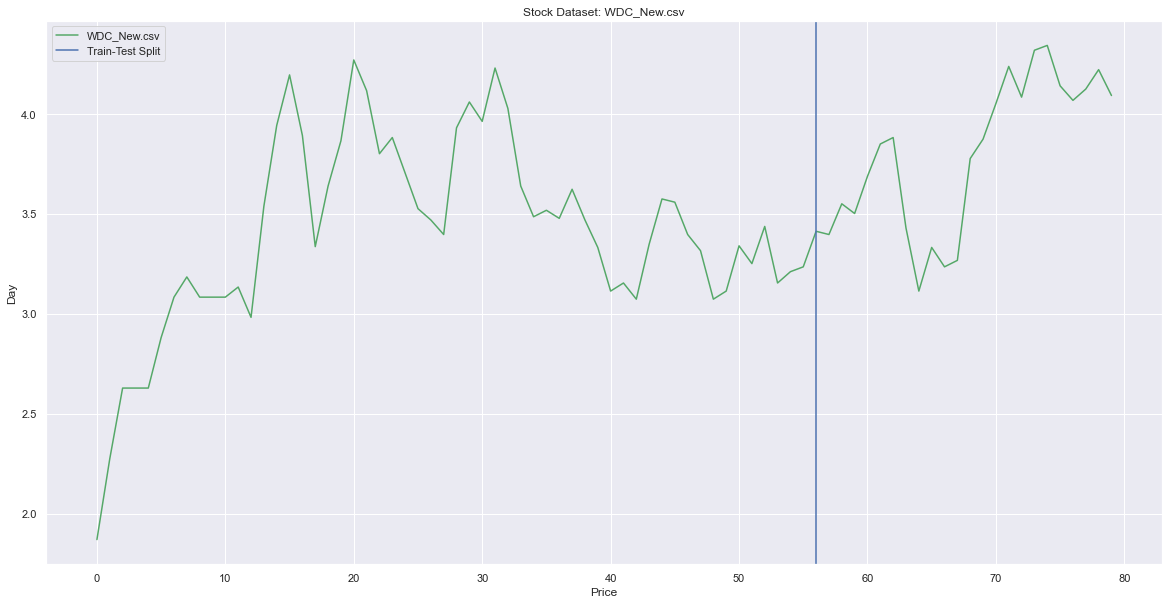

In [11]:
days_test = days_total - days_train

# Split test stage into train and test
test = datasets[-1]
test_dataset = datasets[-1][1]
t_train = test_dataset[:days_train] 
t_test = test_dataset[days_train:days_total]

c = test_dataset.Close.values.tolist()

# Test stock plot
plt.figure(figsize = (20, 10))
plt.title("Stock Dataset: " + test[0])
plt.xlabel('Price')
plt.ylabel('Day')
plt.plot(c, label = test[0], c = 'g')
plt.axvline(x=days_train, label = 'Train-Test Split')
plt.ticklabel_format(style='plain')
plt.legend()

saveFig(out_dir, 'test_stock')
plt.show()

day 9: buy 5 units at price 16.662840, total balance 9983.337160
day 10, sell 5 units at price 16.177515, investment -2.912619 %, total balance 9999.514675,
day 13: buy 5 units at price 19.372565, total balance 9980.142110
day 14, sell 5 units at price 20.262335, investment 4.592939 %, total balance 10000.404445,
day 18: buy 5 units at price 21.718315, total balance 9978.686130
day 19, sell 5 units at price 20.707215, investment -4.655518 %, total balance 9999.393345,
day 21: buy 5 units at price 20.626320, total balance 9978.767025
day 22: buy 5 units at price 21.111655, total balance 9957.655370

total gained -42.344630, total investment -0.423446 %


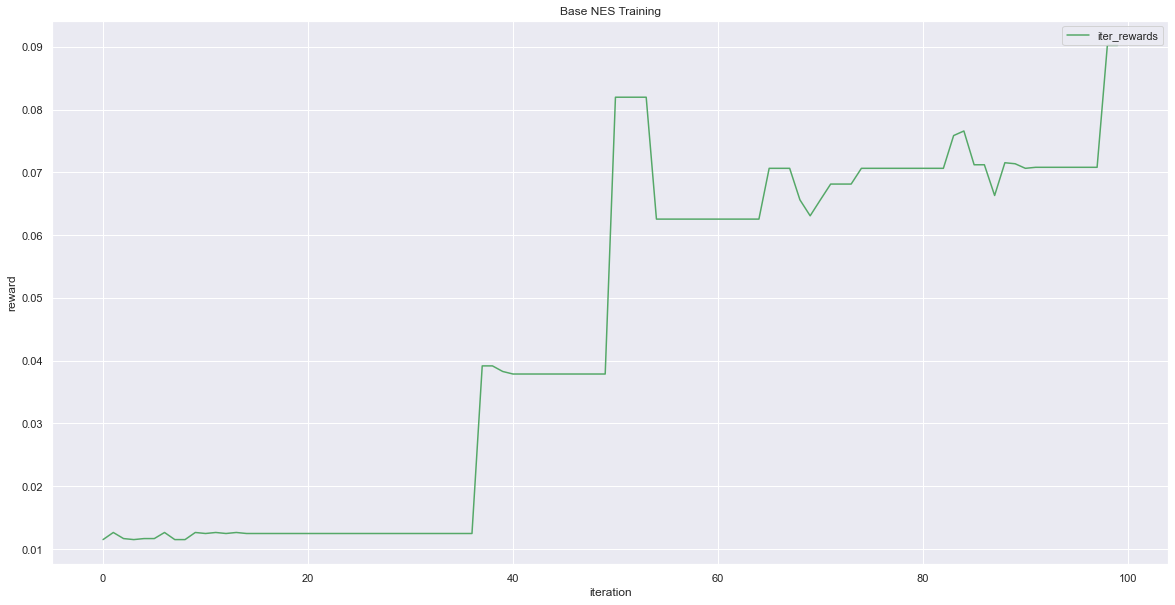

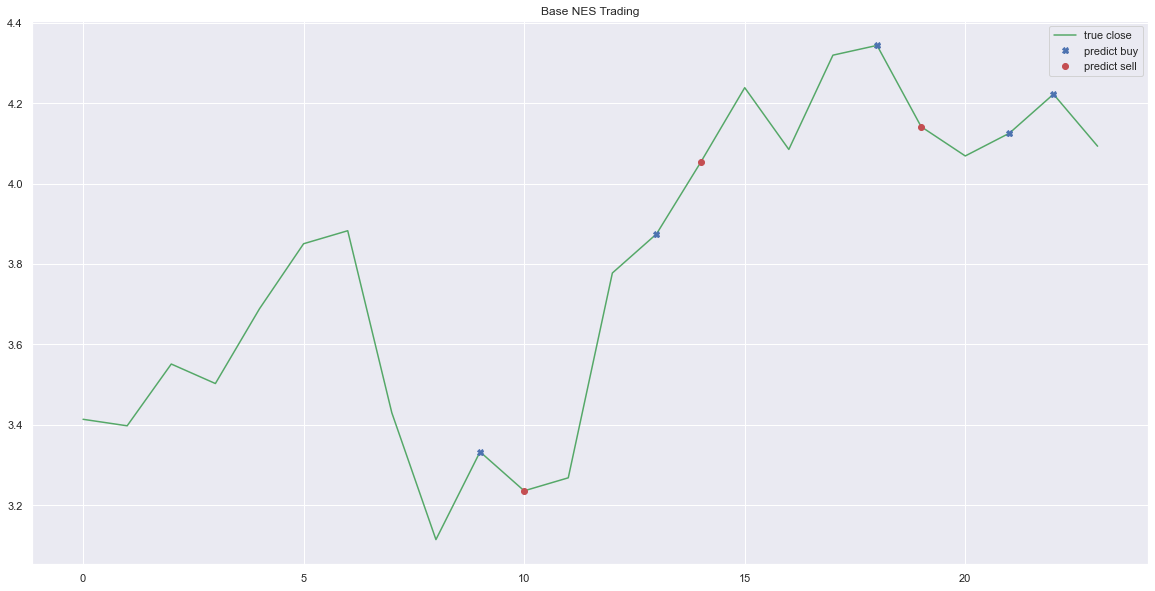

day 9: buy 5 units at price 16.662840, total balance 9983.337160
day 10, sell 5 units at price 16.177515, investment -2.912619 %, total balance 9999.514675,
day 13: buy 1 units at price 3.874513, total balance 9995.640162
day 14, sell 1 units at price 4.052467, investment 4.592939 %, total balance 9999.692629,
day 18: buy 1 units at price 4.343663, total balance 9995.348966
day 19, sell 1 units at price 4.141443, investment -4.655518 %, total balance 9999.490409,
day 21: buy 5 units at price 20.626320, total balance 9978.864089
day 22: buy 5 units at price 21.111655, total balance 9957.752434

total gained -42.247566, total investment -0.422476 %


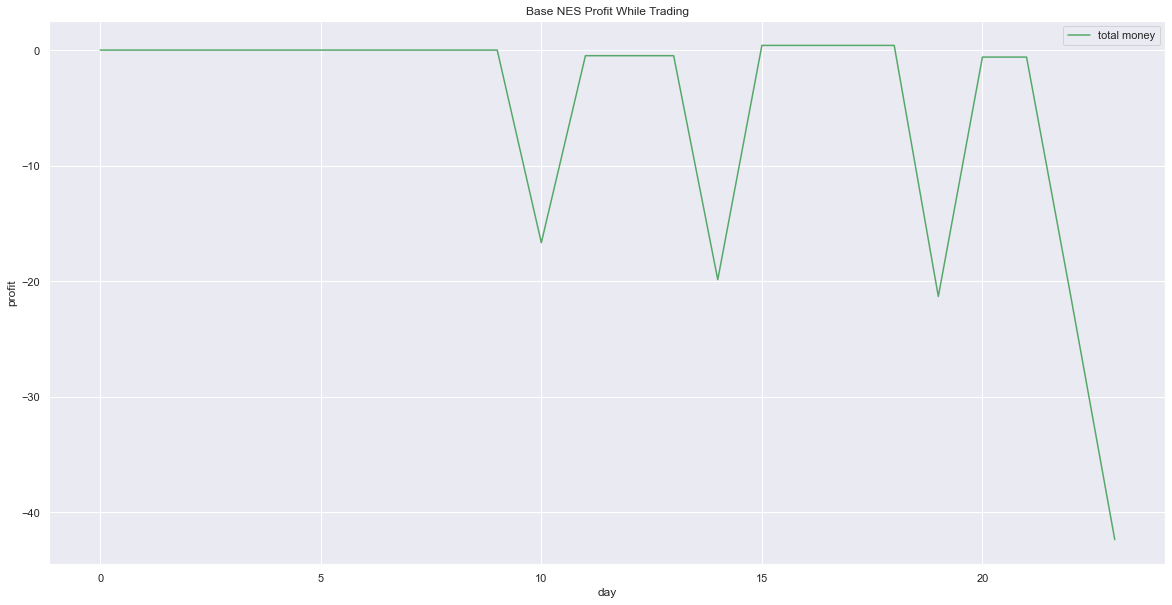

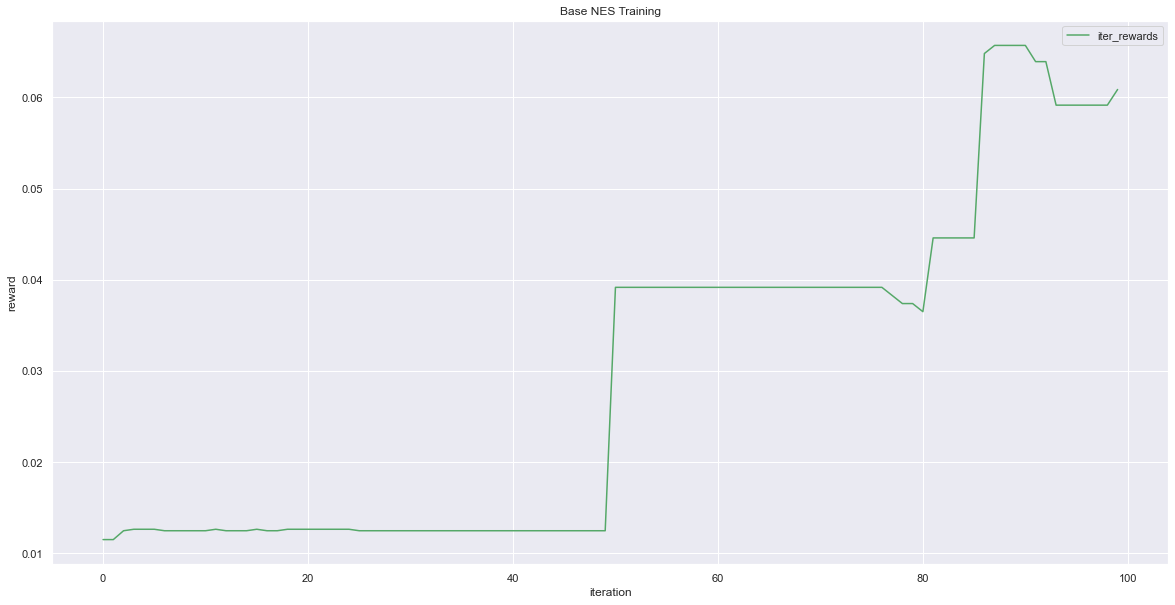

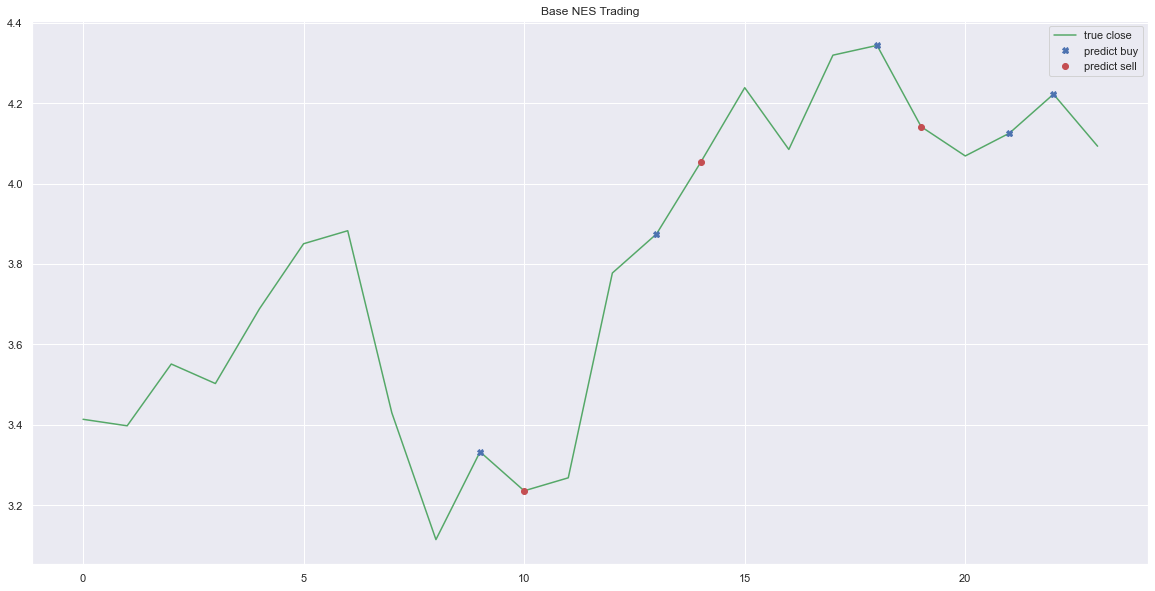

day 9: buy 5 units at price 16.662840, total balance 9983.337160
day 10, sell 5 units at price 16.177515, investment -2.912619 %, total balance 9999.514675,
day 13: buy 0 units at price 0.000000, total balance 9999.514675
day 18: buy 1 units at price 4.343663, total balance 9995.171012
day 19, sell 1 units at price 4.141443, investment -4.655518 %, total balance 9999.312455,
day 21: buy 1 units at price 4.125264, total balance 9995.187191
day 22: buy 5 units at price 21.111655, total balance 9974.075536

total gained -25.924464, total investment -0.259245 %


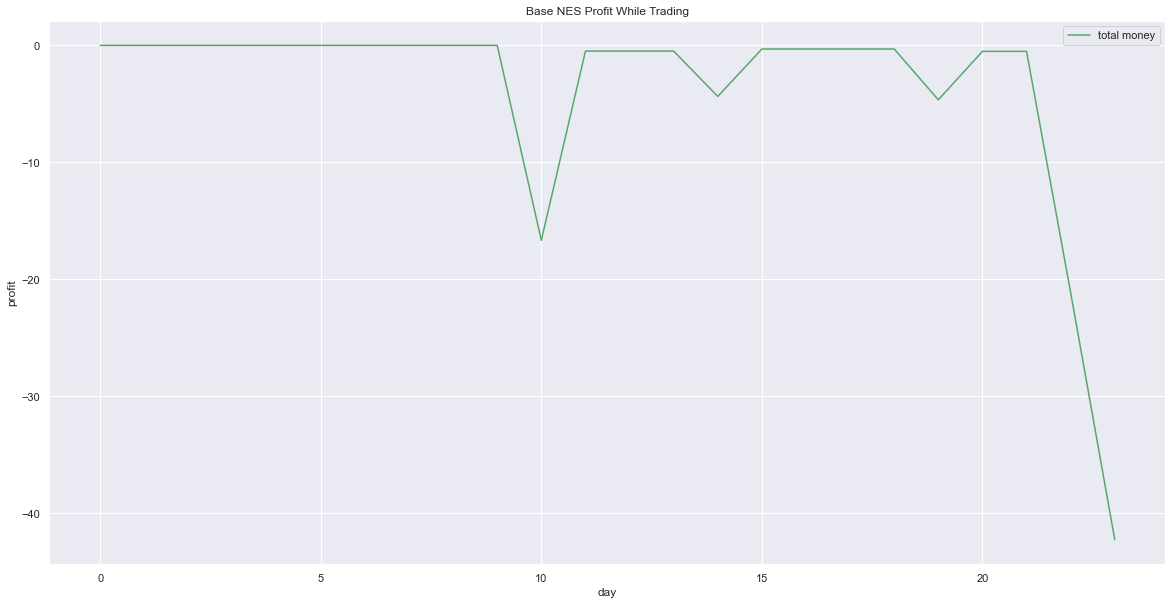

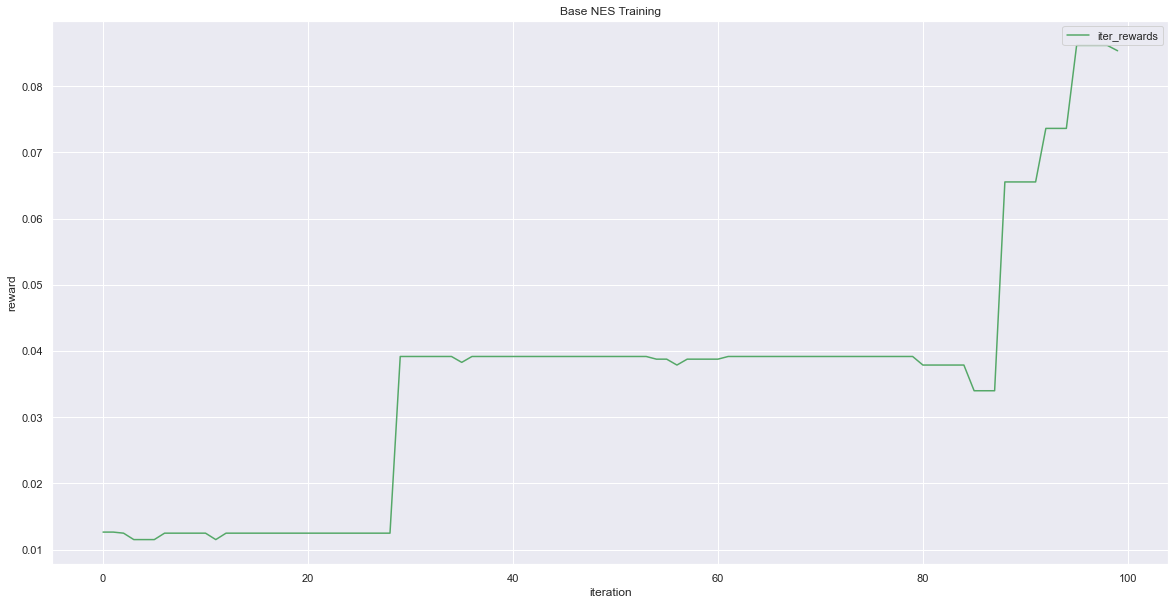

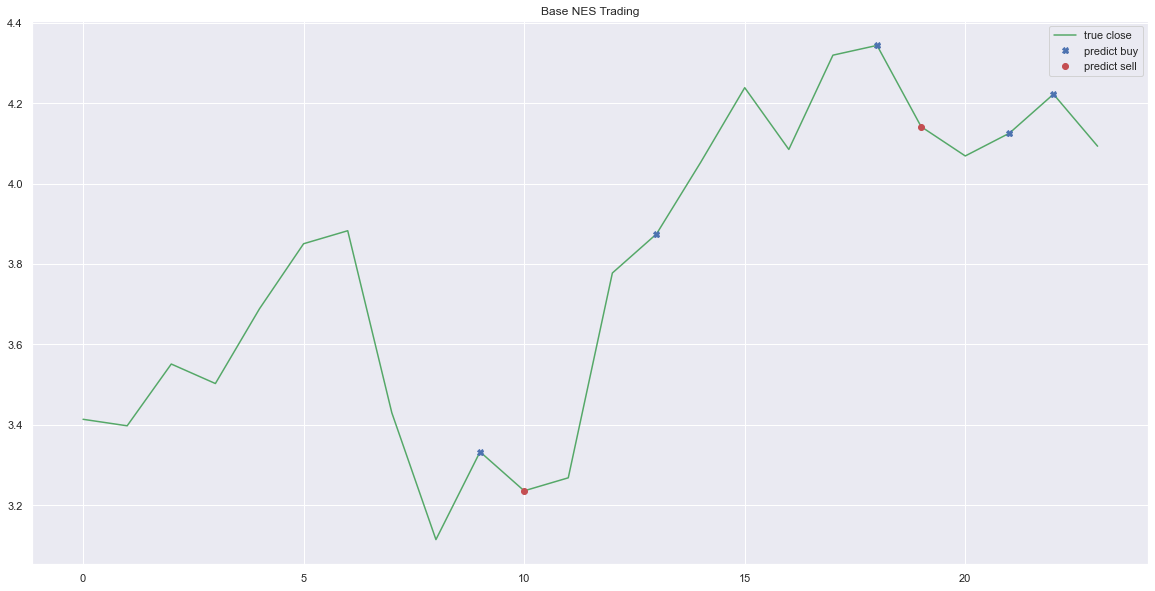

day 12: buy 3 units at price 11.332350, total balance 9988.667650
day 13: buy 5 units at price 19.372565, total balance 9969.295085
day 14, sell 5 units at price 20.262335, investment 78.800822 %, total balance 9989.557420,
day 15, sell 3 units at price 12.715527, investment -34.363224 %, total balance 10002.272947,

total gained 2.272947, total investment 0.022729 %


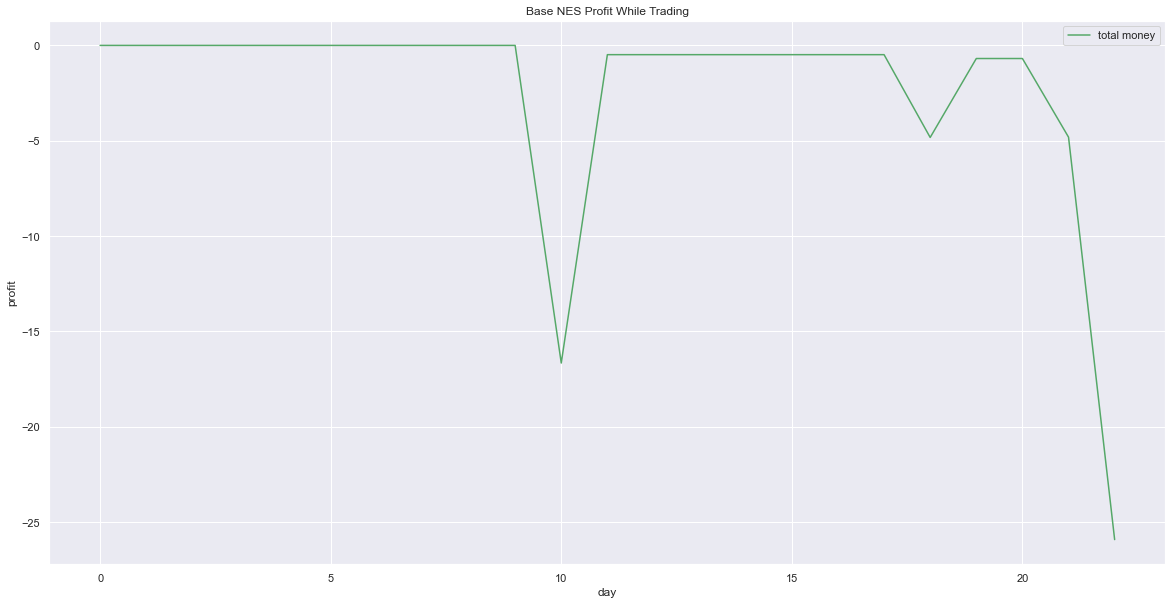

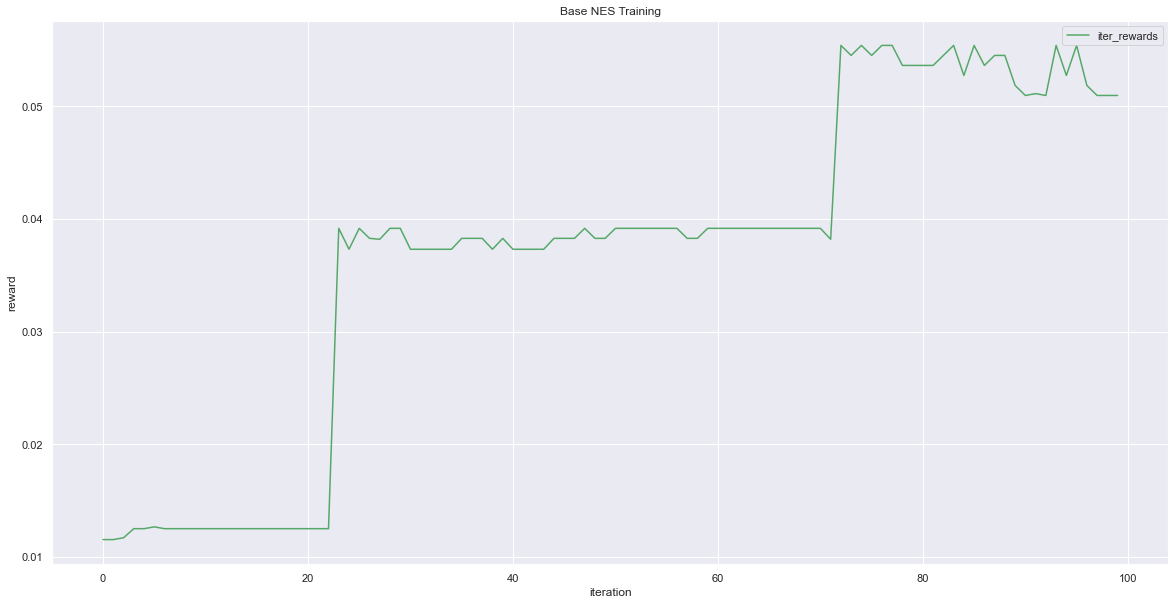

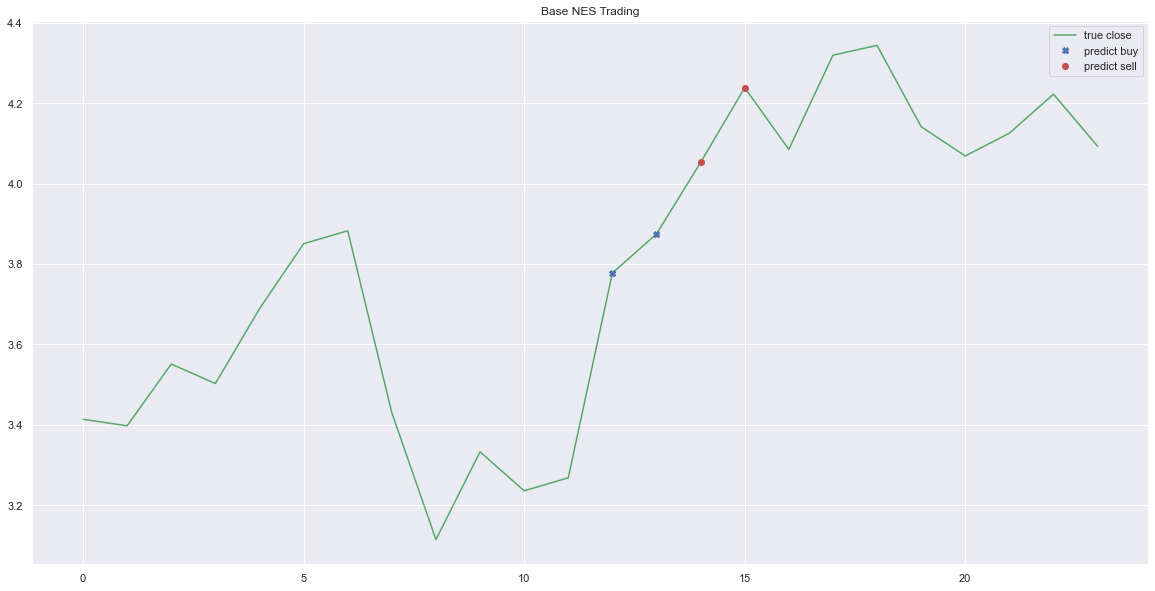

day 9: buy 5 units at price 16.662840, total balance 9983.337160
day 10, sell 5 units at price 16.177515, investment -2.912619 %, total balance 9999.514675,
day 12: buy 1 units at price 3.777450, total balance 9995.737225
day 13: buy 1 units at price 3.874513, total balance 9991.862712
day 14, sell 2 units at price 8.104934, investment 114.560987 %, total balance 9999.967646,
day 18: buy 5 units at price 21.718315, total balance 9978.249331
day 19, sell 5 units at price 20.707215, investment -4.655518 %, total balance 9998.956546,
day 21: buy 1 units at price 4.125264, total balance 9994.831282
day 22: buy 5 units at price 21.111655, total balance 9973.719627

total gained -26.280373, total investment -0.262804 %


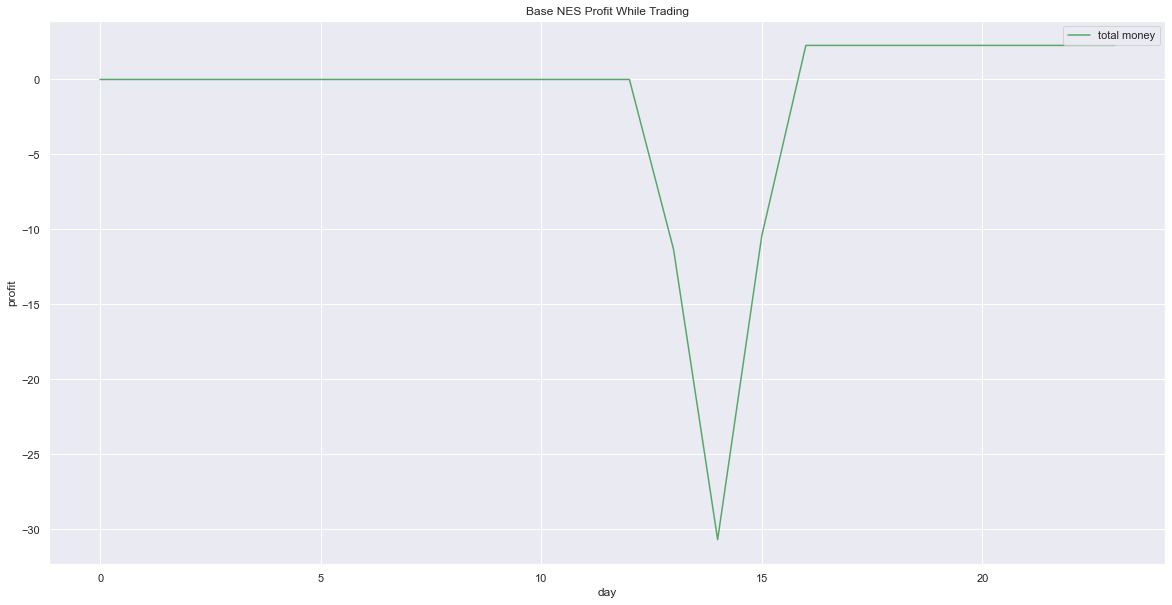

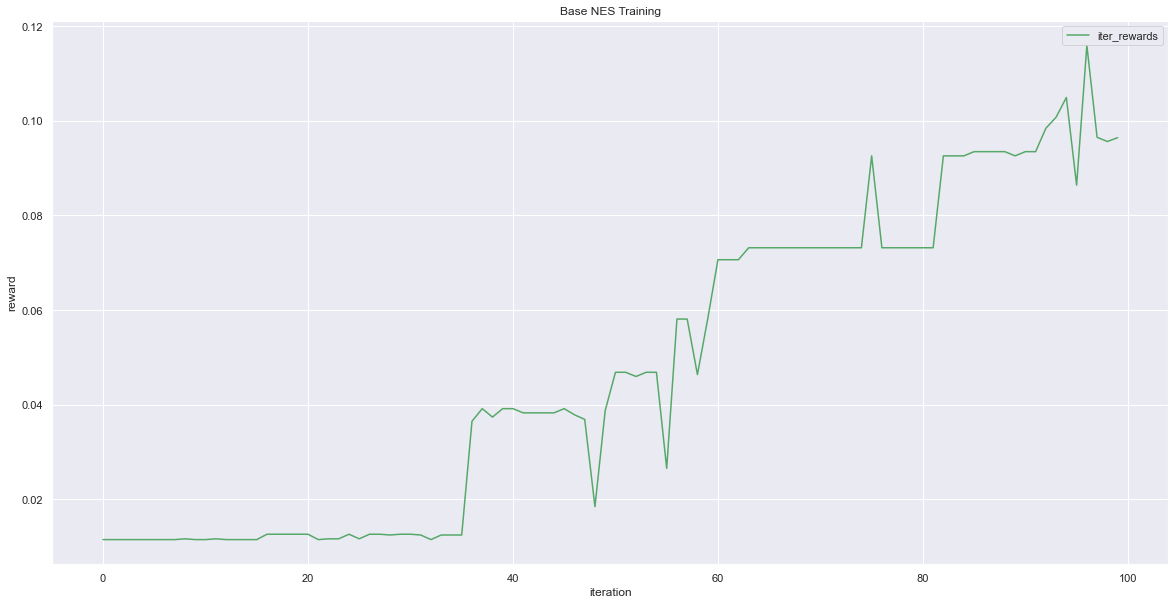

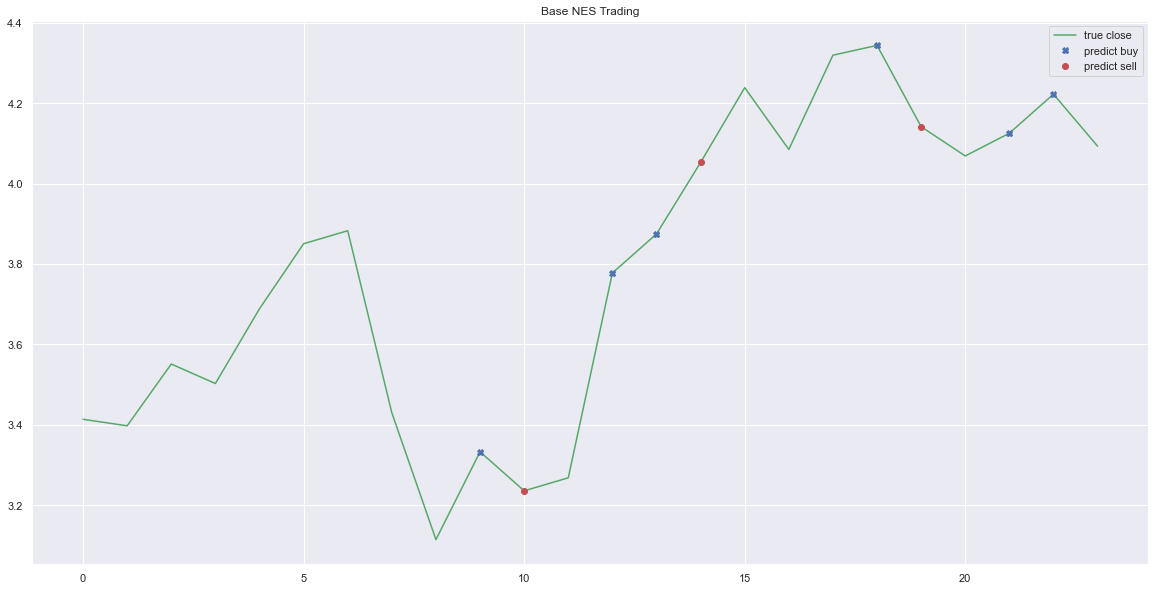

day 5: buy 5 units at price 19.251240, total balance 9980.748760
day 6, sell 5 units at price 19.413015, investment 0.840335 %, total balance 10000.161775,
day 9: buy 5 units at price 16.662840, total balance 9983.498935
day 10, sell 5 units at price 16.177515, investment -2.912619 %, total balance 9999.676450,
day 12: buy 1 units at price 3.777450, total balance 9995.899000
day 13: buy 3 units at price 11.623539, total balance 9984.275461
day 14, sell 4 units at price 16.209868, investment 329.121974 %, total balance 10000.485329,
day 22: buy 5 units at price 21.111655, total balance 9979.373674

total gained -20.626326, total investment -0.206263 %


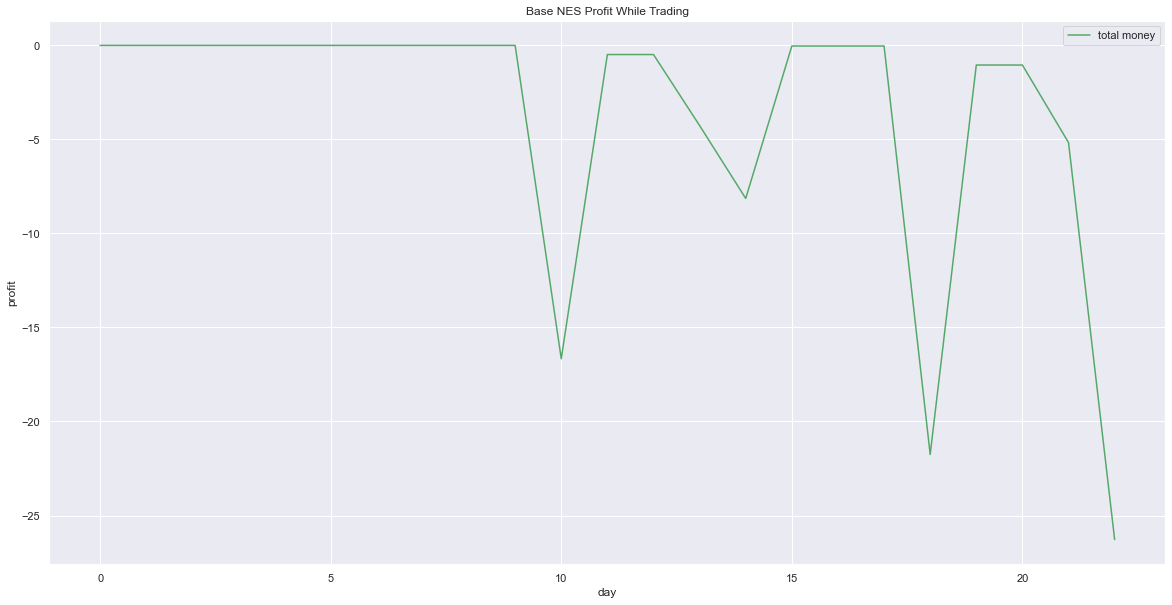

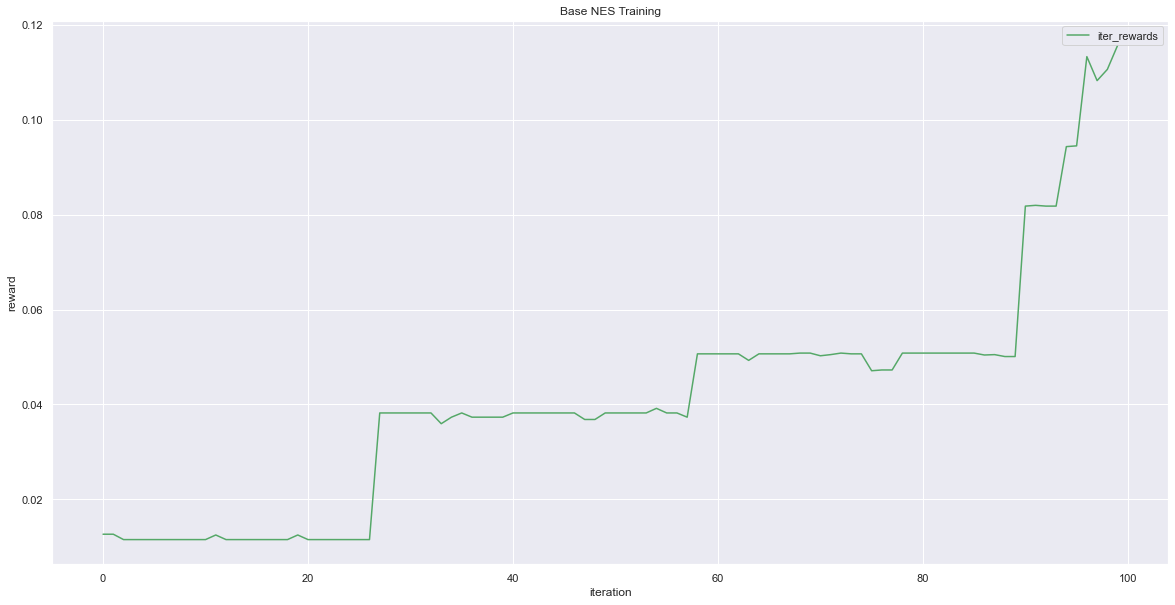

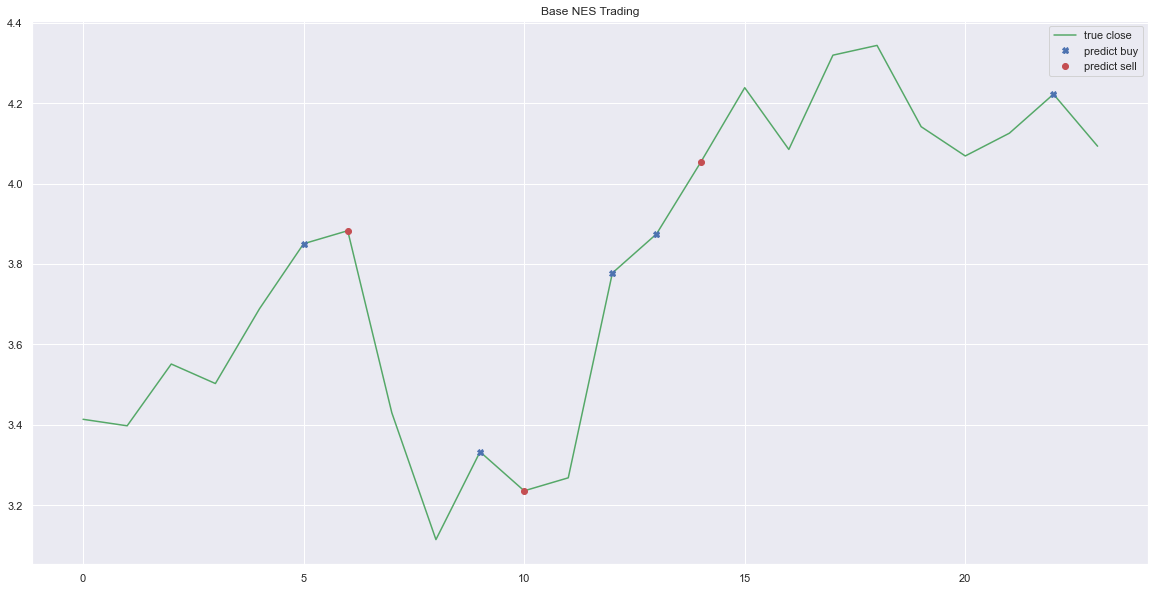

day 9: buy 5 units at price 16.662840, total balance 9983.337160
day 10, sell 5 units at price 16.177515, investment -2.912619 %, total balance 9999.514675,
day 12: buy 1 units at price 3.777450, total balance 9995.737225
day 13: buy 1 units at price 3.874513, total balance 9991.862712
day 14, sell 2 units at price 8.104934, investment 114.560987 %, total balance 9999.967646,
day 18: buy 5 units at price 21.718315, total balance 9978.249331
day 19, sell 5 units at price 20.707215, investment -4.655518 %, total balance 9998.956546,

total gained -1.043454, total investment -0.010435 %


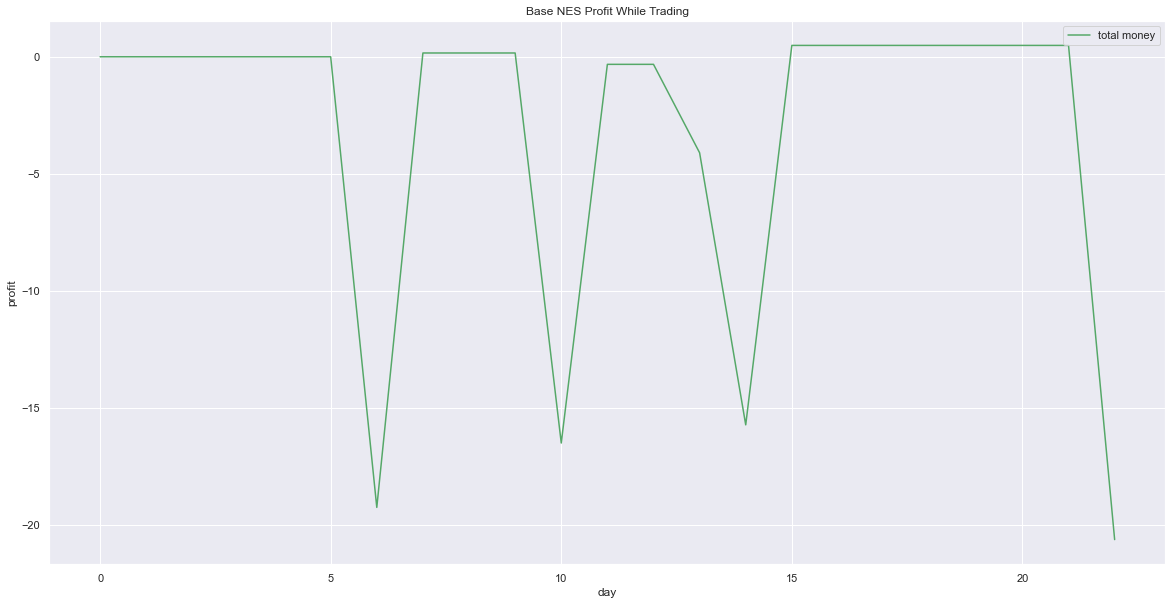

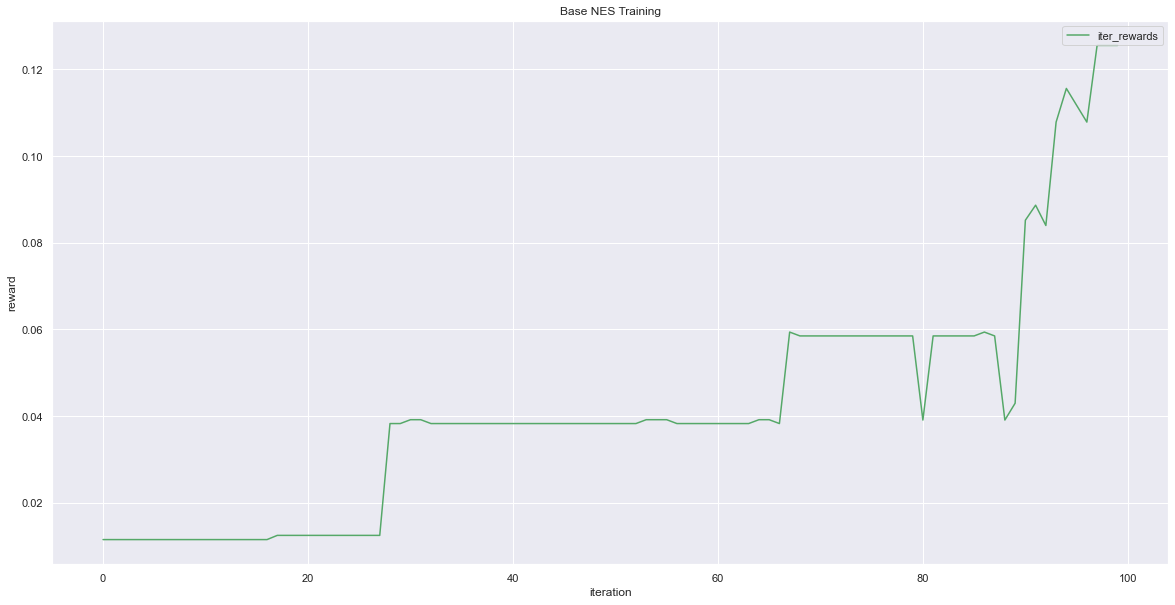

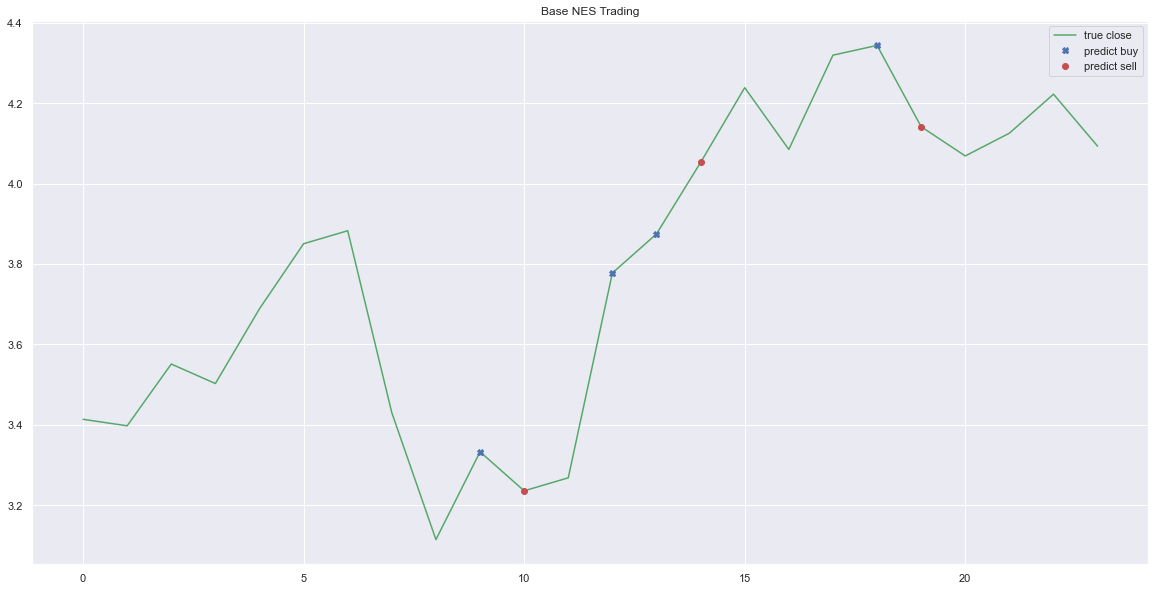

day 5: buy 5 units at price 19.251240, total balance 9980.748760
day 6, sell 5 units at price 19.413015, investment 0.840335 %, total balance 10000.161775,
day 9: buy 5 units at price 16.662840, total balance 9983.498935
day 10, sell 5 units at price 16.177515, investment -2.912619 %, total balance 9999.676450,
day 12: buy 0 units at price 0.000000, total balance 9999.676450
day 13: buy 4 units at price 15.498052, total balance 9984.178398
day 14, sell 4 units at price 16.209868, investment 0.000000 %, total balance 10000.388266,
day 18: buy 0 units at price 0.000000, total balance 10000.388266
day 21: buy 1 units at price 4.125264, total balance 9996.263002
day 22: buy 5 units at price 21.111655, total balance 9975.151347

total gained -24.848653, total investment -0.248487 %


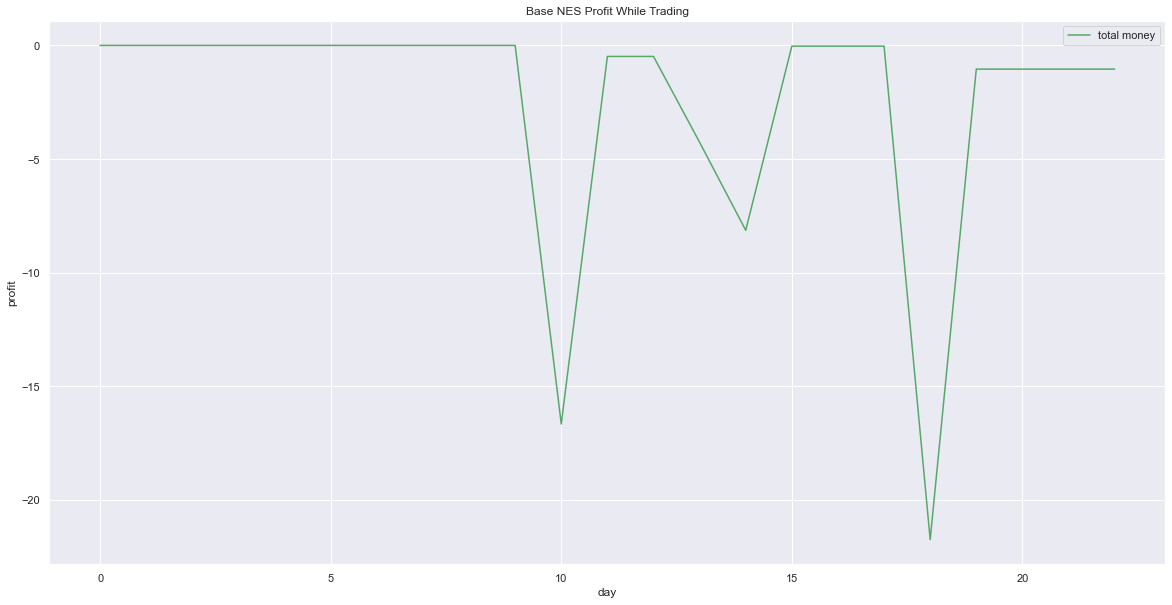

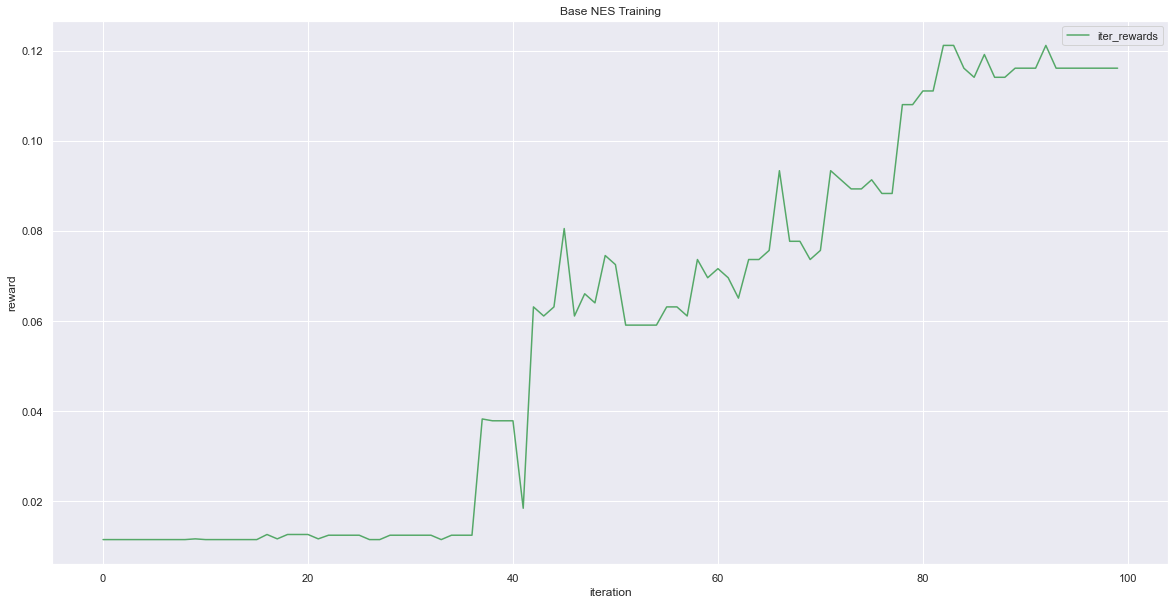

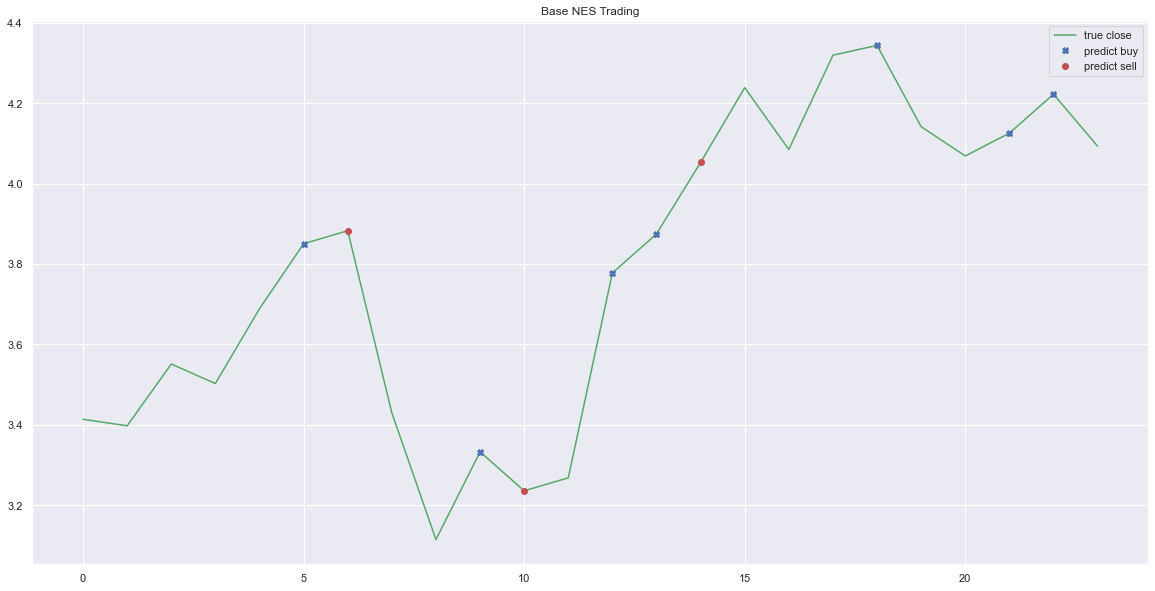

day 9: buy 5 units at price 16.662840, total balance 9983.337160
day 10, sell 5 units at price 16.177515, investment -2.912619 %, total balance 9999.514675,
day 12: buy 5 units at price 18.887250, total balance 9980.627425
day 13: buy 5 units at price 19.372565, total balance 9961.254860
day 14, sell 5 units at price 20.262335, investment 7.280493 %, total balance 9981.517195,
day 15, sell 5 units at price 21.192545, investment 9.394626 %, total balance 10002.709740,
day 18: buy 5 units at price 21.718315, total balance 9980.991425
day 19, sell 5 units at price 20.707215, investment -4.655518 %, total balance 10001.698640,
day 21: buy 5 units at price 20.626320, total balance 9981.072320
day 22: buy 5 units at price 21.111655, total balance 9959.960665

total gained -40.039335, total investment -0.400393 %


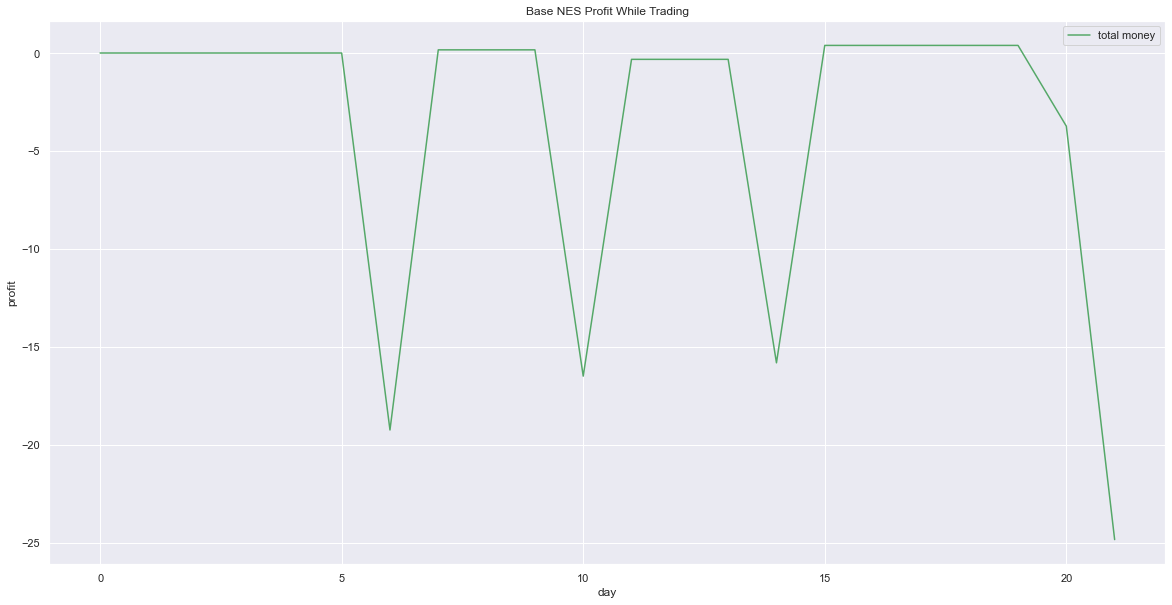

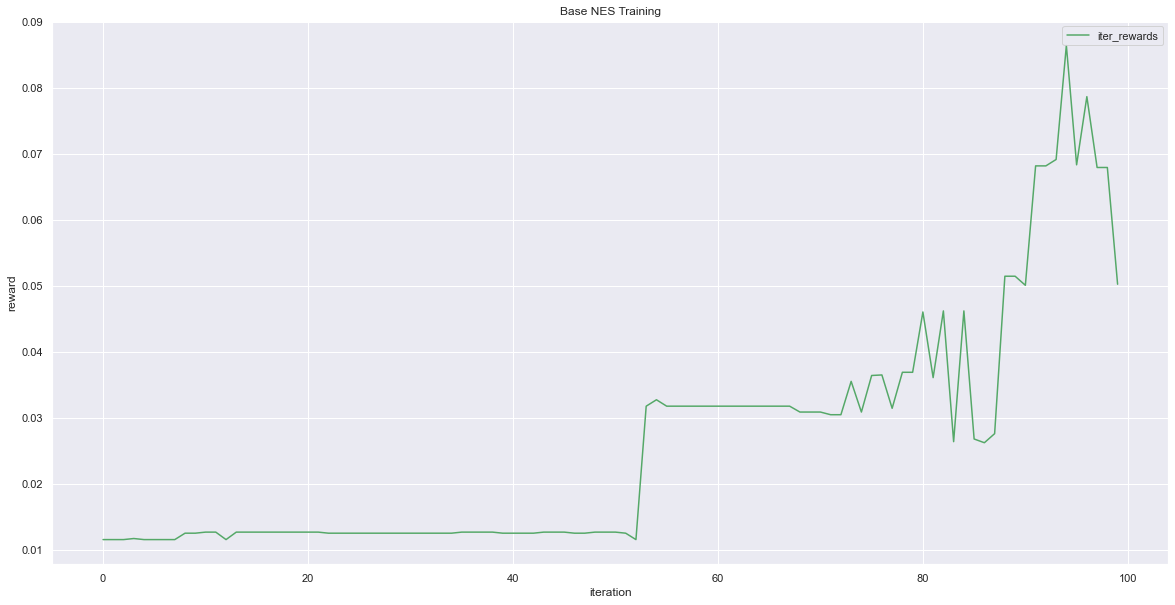

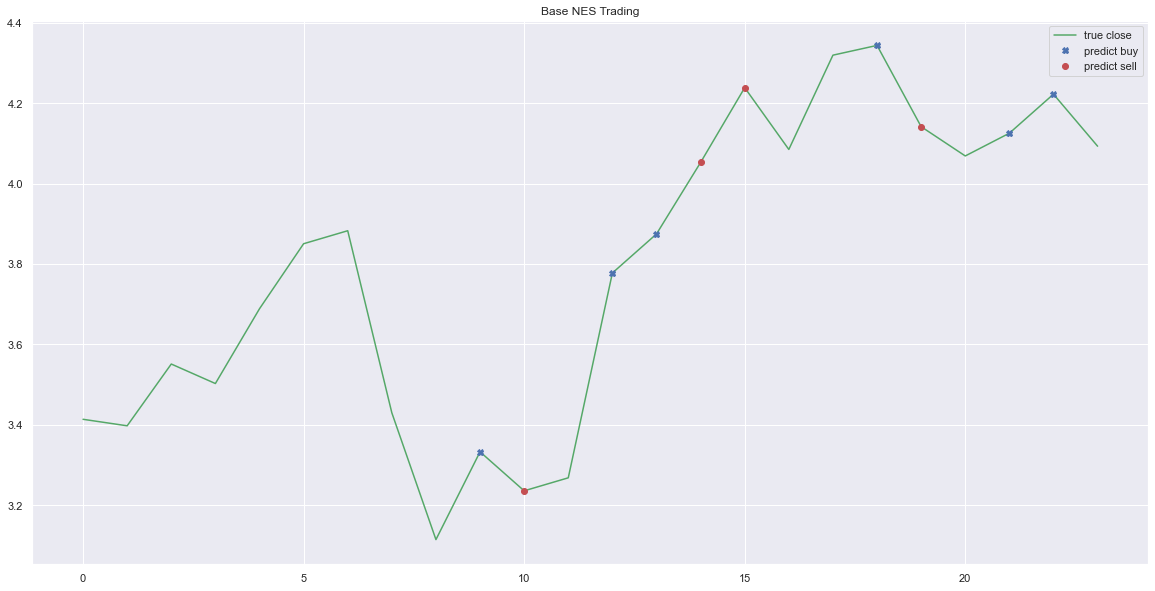

day 13: buy 3 units at price 11.623539, total balance 9988.376461
day 14, sell 3 units at price 12.157401, investment 4.592939 %, total balance 10000.533862,

total gained 0.533862, total investment 0.005339 %


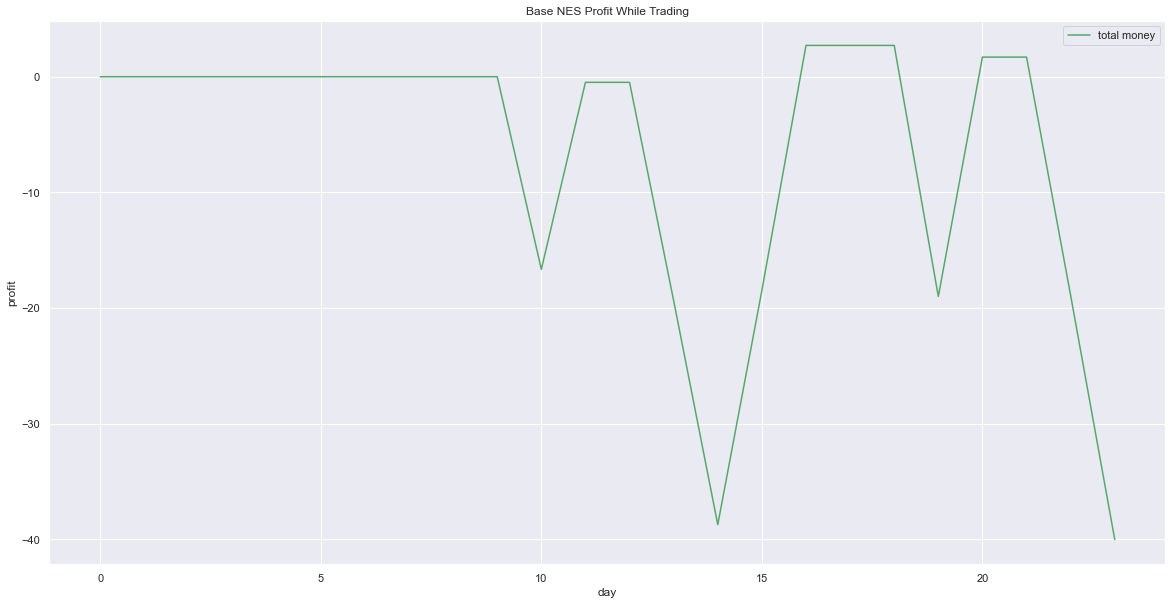

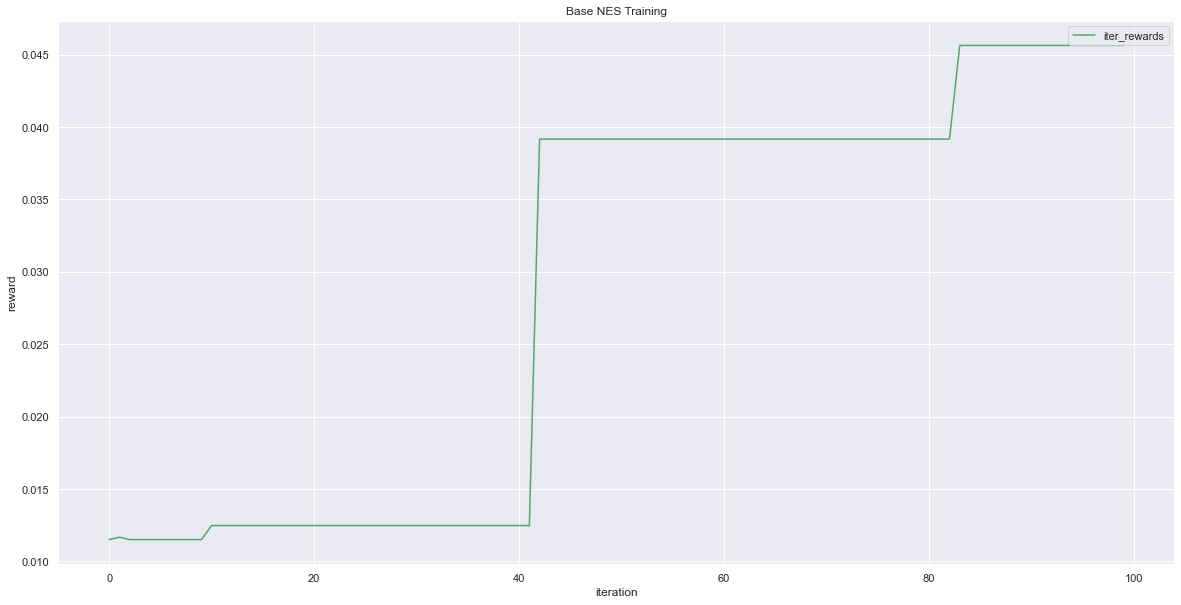

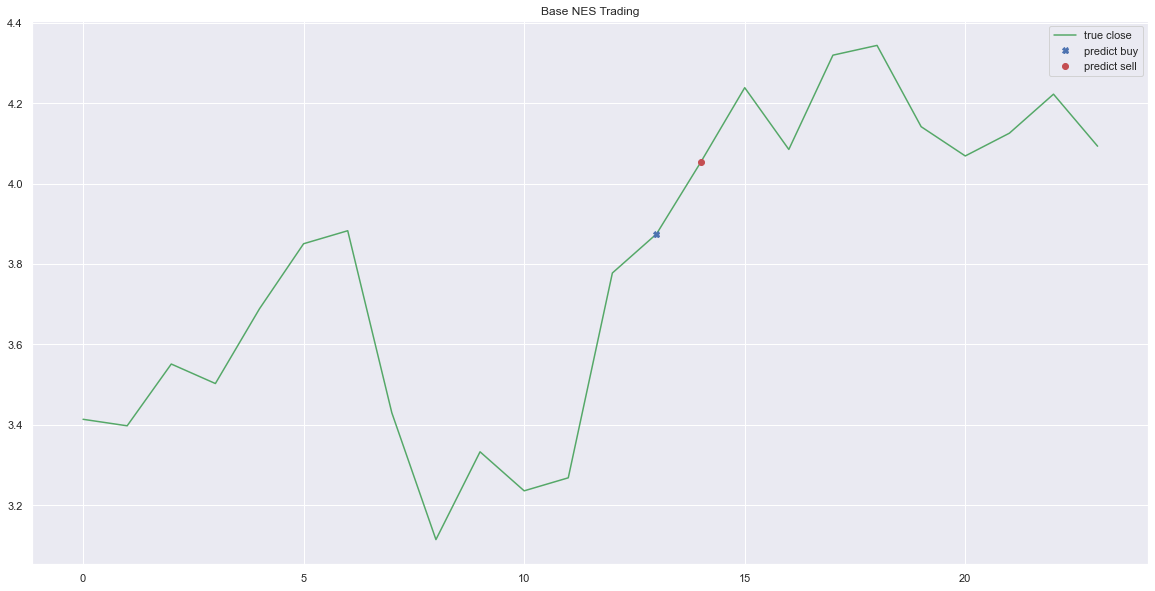

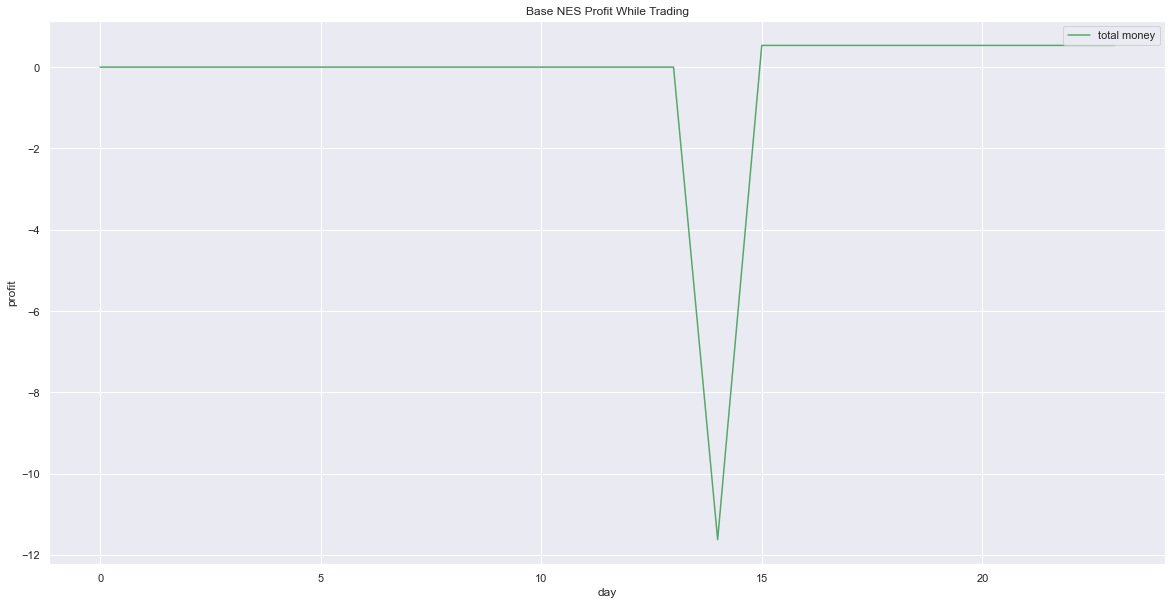

In [12]:
profits = []
labels = []

epoch_rewards = []
track_money = []

for i in range(0,sample_size):
    # Train
    close = t_train.Close.values.tolist()
    model.set_weights([feed_w1, decision_w2, buy_w3, feed_w4])
    agent = Agent(
        model = model,
        money = 10000,
        max_buy = 5,
        max_sell = 5,
        close = close,
        window_size = window_size,
        skip = 1,
    )
    agent.fit(iterations = num_iter_test, checkpoint = 10)       
    
    # Train plots
    plt.figure(figsize = (20, 10))
    plt.title("Base NES Training")
    plt.xlabel('iteration')
    plt.ylabel('reward')
    plt.plot(epoch_rewards, label = 'iter_rewards', c = 'g')
    plt.ticklabel_format(style='plain')
    plt.legend()
    saveFig(out_dir, 'train')
#     plt.show()
    writeCSV(out_dir, "train_data", epoch_rewards)
    epoch_rewards = []
    
    #Test
    close = t_test.Close.values.tolist()
    agent = Agent(
        model = model,
        money = 10000,
        max_buy = 5,
        max_sell = 5,
        close = close,
        window_size = window_size,
        skip = 1,
    )
    
    # Test trade (plots trading in agent.but())
    agent.buy()
    profit = agent.get_profit()
    profits.append(profit)
    
    # Profit plots
    plt.figure(figsize = (20, 10))
    plt.ticklabel_format(style='plain')
    plt.title("Base NES Profit While Trading")
    plt.xlabel('day')
    plt.ylabel('profit')
    plt.plot(track_money, label = 'total money', c = 'g')
    plt.legend()
    saveFig(out_dir, 'trade_balance')
#     plt.show()
    writeCSV(out_dir, "profit_data", track_money)
    
    track_money = []
    labels.append(str(i))

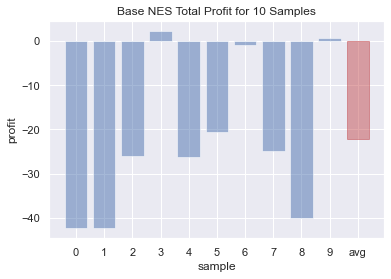

In [13]:
avg_profit = statistics.mean(profits) 
profits.append(avg_profit)
labels.append("avg")
y_pos = np.arange(len(profits))
plt.bar(y_pos, profits, align='center', alpha=0.5)[sample_size].set_color('r')
plt.xticks(y_pos, labels)
plt.ylabel('profit')
plt.xlabel('sample')
plt.title("Base NES Total Profit for " + str(len(profits) - 1) + " Samples")
saveFig(out_dir, 'results')
plt.show()
writeCSV(out_dir,"results_data",profits[:-1])